In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook
import scipy.stats as stats   
import scipy.cluster.vq
import datetime
import os
pd.set_option('display.width', 200)

tw_span = 5.0   #定义时间窗大小（分钟数）
#载入ap点位
ap = pd.read_csv('E:/HuangShan/info/AP.csv', encoding='gbk')
ap.location = ap.location.astype(str)
#不同区域的代码
area = pd.read_csv('E:/HuangShan/info/area.csv', encoding='gbk')
area.area = area.area.astype(str)
ap = pd.merge(ap, area).sort_values('ap_seq')
ap_reduce = ap.loc[:,['ap_seq','area_id']]

#import经过整理的vendor
vendor = pd.read_csv('e:/ArchSchool/info/oui.csv')
vendor.columns = ['mac6', 'vendor']
vendor['vendor'] = vendor.vendor.str.replace('"', '')
vendor['mac6'] = vendor.mac6.str.upper()
v_names = ['Apple', 'Xiaomi', 'Samsung', 'Huawei', 'Motorola', 'Microsoft', 'Oppo', 'H3C', 'Aruba', 'TP-LINK', 'D-Link', 'zte',
           'Murata', 'MEIZU', 'Intel', 'vivo', 'Hon Hai', 'HTC', 'Lenovo Mobile', 'Cisco', 'Ereneben', 'AzureWave', 'ASUSTek',
           'Sony Mobile', 'Liteon', 'LG Electronics', 'Nokia', 'Amazon', 'OnePlus', 'SYNTECH (HK)', 'Gionee', 'Smartisan', 'BBK',
           'Yulong', 'Qiku', 'Hisense', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Dell', 'Net Com', 'Bilian', 'EASY3CALL',
           'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 'Le Shi Zhi Xin', 'Hui Zhou Gaoshengda', 
           'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private', 'LONGCHEER', 'TCT']
for name in v_names:
    vendor['vendor'] = np.where(vendor.vendor.str.contains(name, case=False), name, vendor.vendor)
'''
device_name = ['H3C', 'Aruba', 'TP-LINK', 'D-Link', 'Intel', 'Hon Hai', 'Cisco', 'AzureWave', 'Liteon', 
               'SYNTECH (HK)', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Net Com', 'Bilian', 'EASY3CALL',
                'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 'Le Shi Zhi Xin', 'Hui Zhou Gaoshengda',
                'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private']
'''
mobile_name = ['Apple', 'Murata', 'Xiaomi', 'Huawei', 'Samsung', 'Oppo', 'vivo', 'MEIZU', 'Yulong', 'zte', 
               'Sony Mobile', 'BBK', 'Lenovo Mobile', 'HTC', 'Smartisan', 'LG Electronics', 'Qiku', 'Microsoft', 'Gionee', 
               'TCT', 'OnePlus', 'LONGCHEER', 'Hisense', 'Motorola', 'Nokia']
vendor['mobile']=np.where(vendor.vendor.isin(mobile_name), True, False)

C:\Anaconda2\Lib\site-packages\ipykernel\__main__.py:35: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [3]:
#载入数据
dir_path = 'E:/HuangShan/sequence'
files = os.listdir(dir_path)
data = []
fileMax = 100
fileCnt = 0
for datafile in files:
    path = dir_path + '/' + datafile
    frame = pd.read_csv(path)                 
    data.append(frame)
    fileCnt += 1
    if fileCnt >= fileMax:
        break
data = pd.concat(data, ignore_index = False)
data['date'] = pd.to_datetime(data.date)

In [4]:
del data['Unnamed: 1']
del data['mac.1']
del data['area_previous']

In [5]:
del data['cnt']
del data['ap_seq']

In [7]:
data['gap'] = data.tw_next - data.tw_all 
data.to_csv('E:/HuangShan/area_flow.csv', index=False)

In [44]:
area_flow = data[data.type==0]

In [45]:
net = area_flow.groupby(by=['area_id','area_next']).apply(len).reset_index(name='weight')
gap = area_flow.groupby(by=['area_id','area_next']).gap.mean().reset_index(name='gap')
net = pd.merge(net, gap, on=['area_id','area_next'])

In [46]:
area_stay = area_flow[area_flow.area_id==area_flow.area_next]

<IPython.core.display.Javascript object>


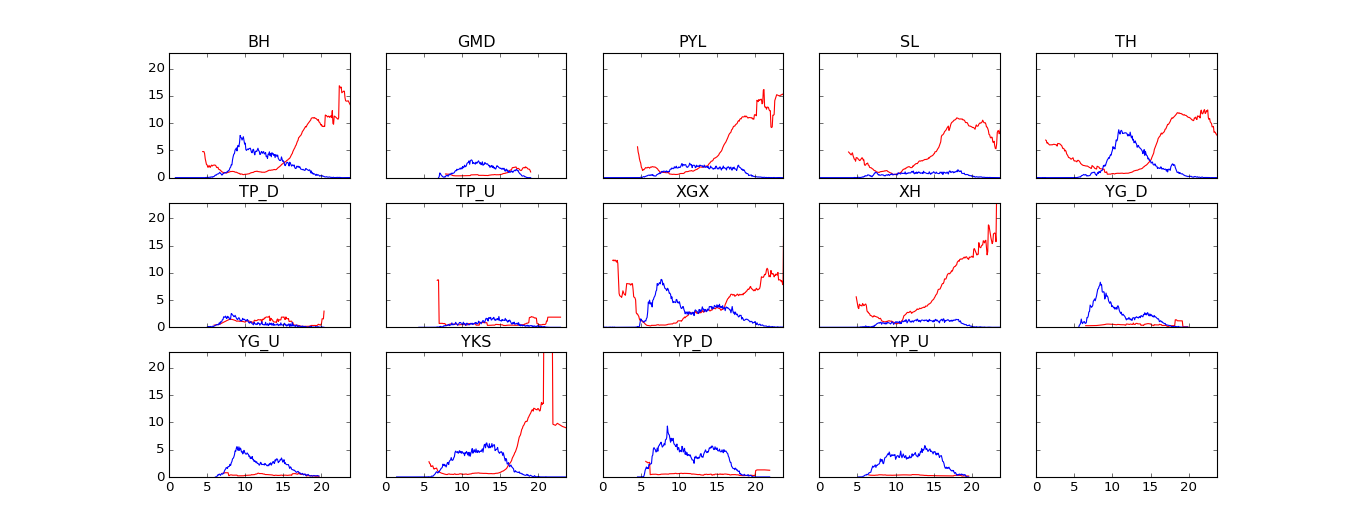

C:\Anaconda2\Lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()


In [49]:
fig, axes = plt.subplots(3, 5, sharex='all', sharey='all')
for i in range(14):
    temp = area_stay[area_stay.area_id==i]
    gap_ = pd.rolling_mean(temp.groupby('tw').gap.mean(),12)
    cnt_ = temp.groupby('tw').size()
    axes[i/5, i%5].plot(gap_.index/12.0, gap_/12.0, c='red')
    axes[i/5, i%5].plot(gap_.index/12.0, cnt_/100, c='blue')  
    axes[i/5, i%5].set_title(area.area[i]);

C:\Anaconda2\Lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


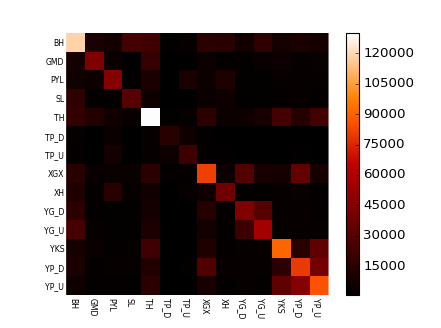

In [21]:
traffic = np.zeros([len(area),len(area)])
for i in range(len(net)):
    traffic[net.area_id[i],net.area_next[i]] = net.weight[i]
plt.imshow(traffic, cmap='gist_heat', interpolation='none');
plt.colorbar()
plt.axis('off')
for i in range(len(area)):
    plt.text(-0.6,i+0.2,area.area[i], ha='right',size=7)
    plt.text(i+0.1,14.0,area.area[i], ha='right',size=7, rotation=-90)

<IPython.core.display.Javascript object>


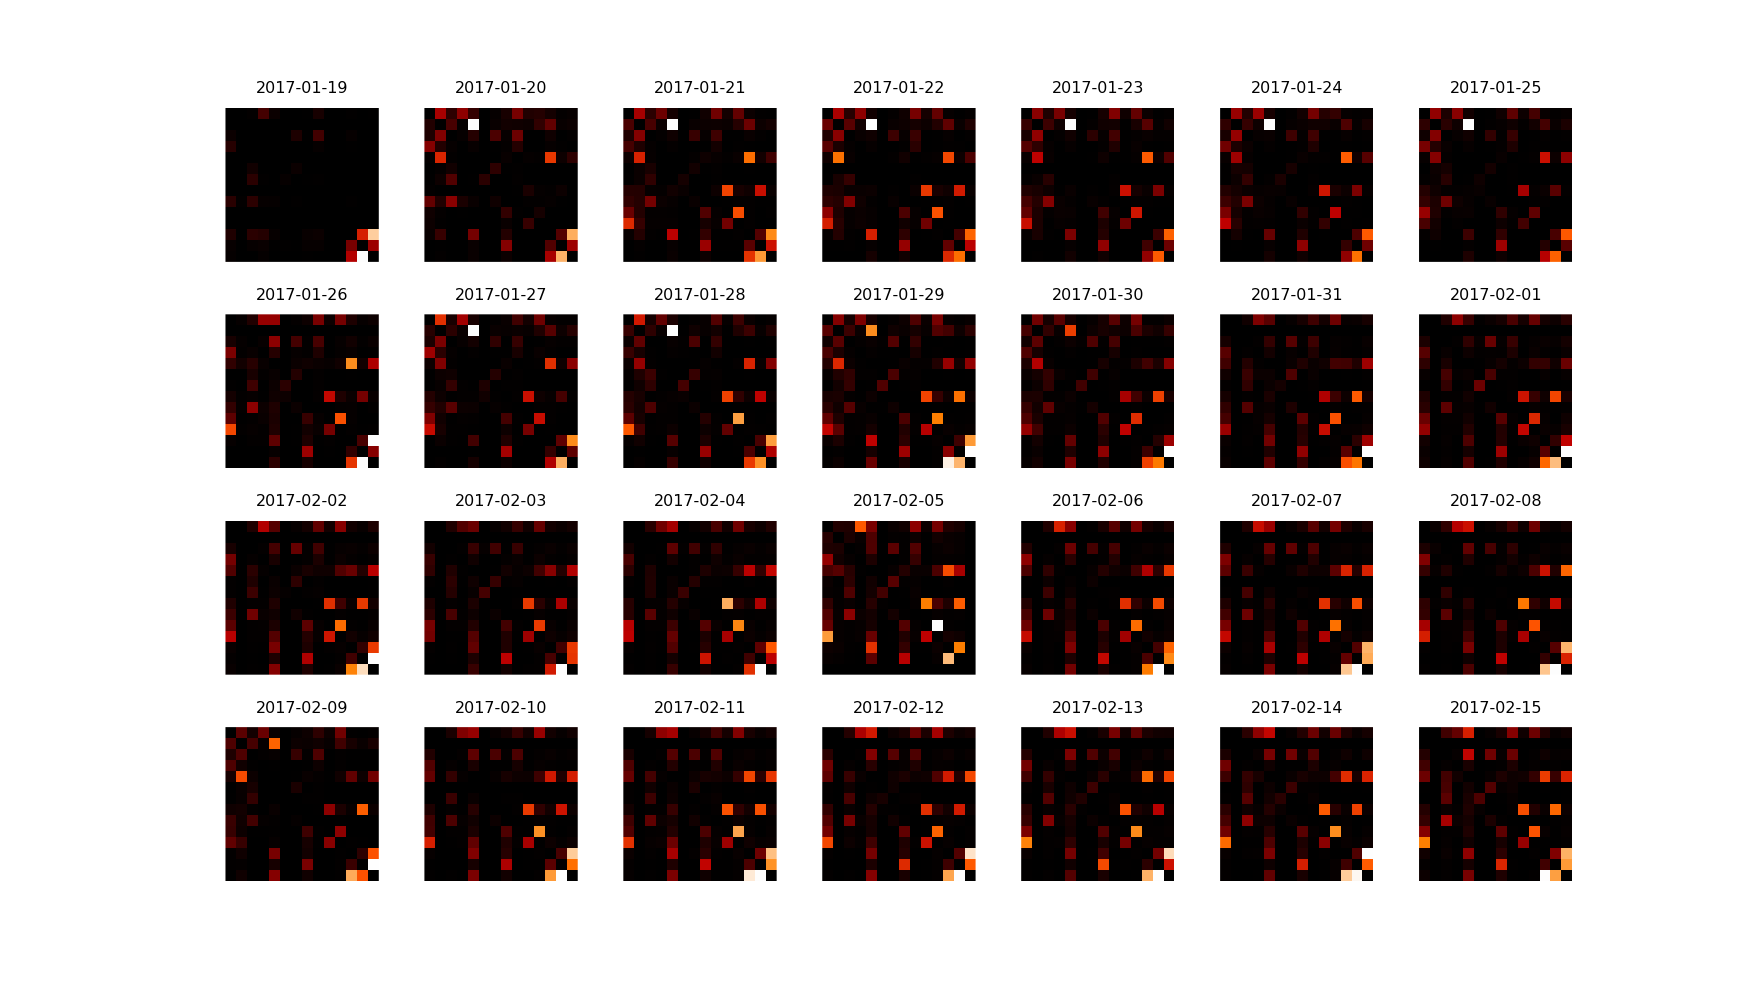

C:\Anaconda2\Lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [133]:
fig, axes = plt.subplots(4, 7, sharex='all', sharey='all')
for i in range(28):
    temp = area_flow[(area_flow.date-area_flow.date.min())/pd.Timedelta(days=1)==i]
    net = temp.groupby(by=['area_id','area_next']).apply(len).reset_index(name='weight')
    gap = temp.groupby(by=['area_id','area_next']).gap.mean().reset_index(name='gap')
    net = pd.merge(net, gap, on=['area_id','area_next'])
    traffic = np.zeros([len(area),len(area)])
    for j in range(len(net)):
        traffic[net.area_id[j],net.area_next[j]] = net.weight[j]
    for j in range(len(area)):
        traffic[j, j] = 0
        
    axes[i/7, i%7].imshow(traffic, cmap='gist_heat', interpolation='none');
    axes[i/7, i%7].axis('off')
    axes[i/7, i%7].set_title(str(area_flow.date.min()+i*pd.Timedelta(days=1))[:10]);

<IPython.core.display.Javascript object>


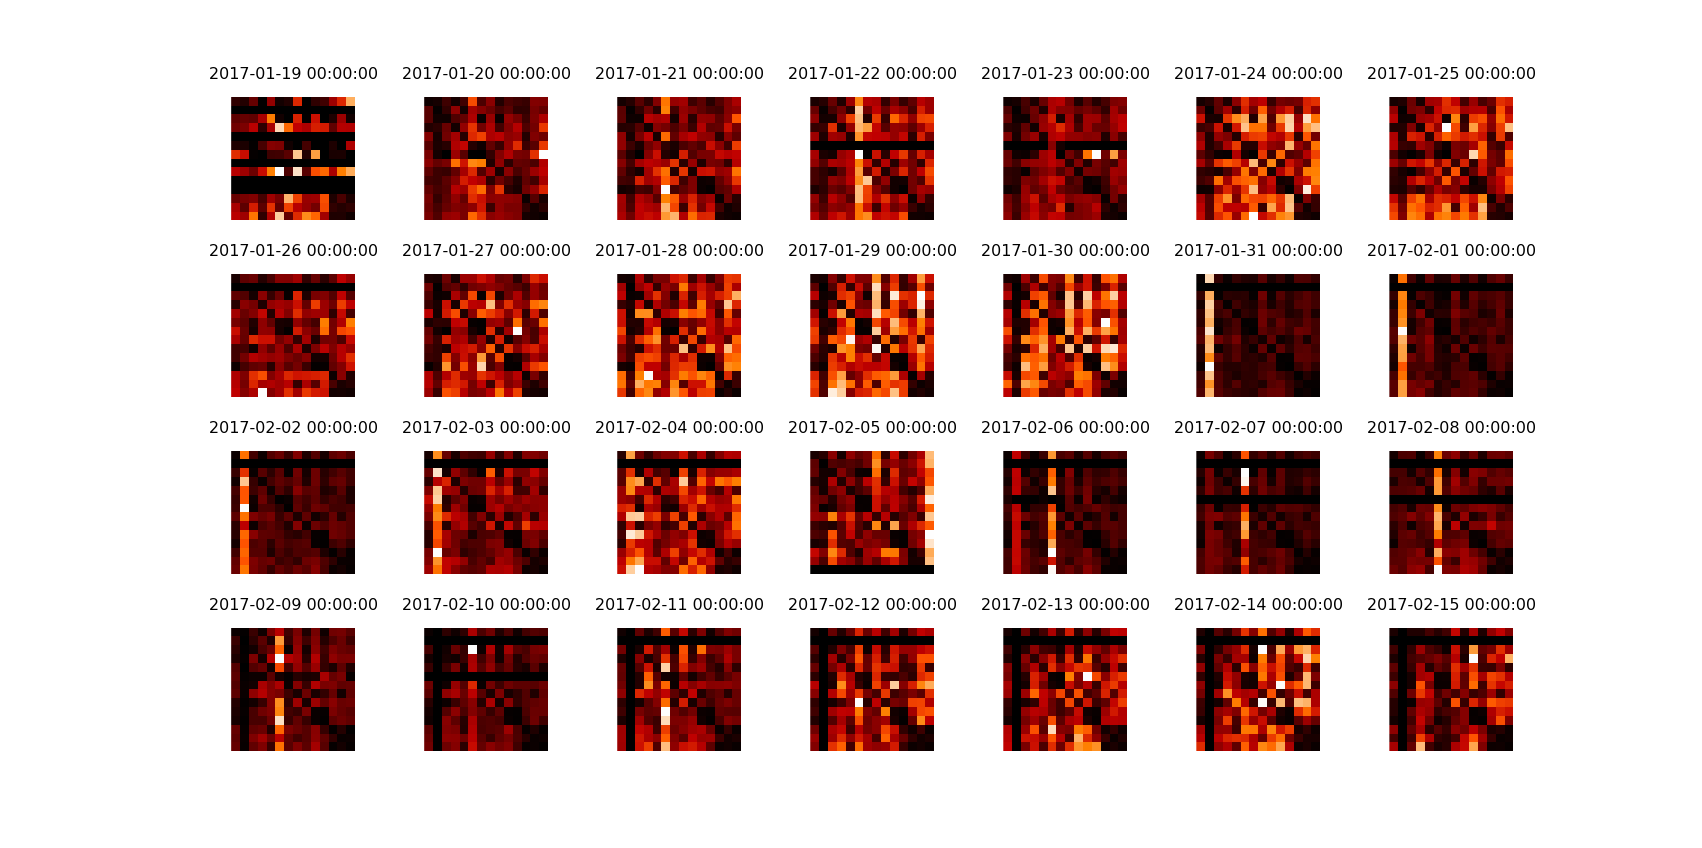

C:\Anaconda2\Lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [34]:
fig, axes = plt.subplots(4, 7, sharex='all', sharey='all')
for i in range(28):
    temp = area_flow[(area_flow.date-area_flow.date.min())/pd.Timedelta(days=1)==i]
    net = temp.groupby(by=['area_id','area_next']).apply(len).reset_index(name='weight')
    gap = temp.groupby(by=['area_id','area_next']).gap.mean().reset_index(name='gap')
    net = pd.merge(net, gap, on=['area_id','area_next'])
    traffic = np.zeros([len(area),len(area)])
    for j in range(len(net)):
        traffic[net.area_id[j],net.area_next[j]] = net.gap[j]
    axes[i/7, i%7].imshow(traffic, cmap='gist_heat', interpolation='none');
    axes[i/7, i%7].axis('off')
    axes[i/7, i%7].set_title(str(area_flow.date.min()+i*pd.Timedelta(days=1))[:10]);

In [66]:
net = area_flow.groupby(by=['area_id','area_next']).apply(len).reset_index(name='weight')
gap = area_flow.groupby(by=['area_id','area_next']).gap.mean().reset_index(name='gap')
net = pd.merge(net, gap, on=['area_id','area_next'])
area.columns = ['area','x','y','area_id']
net = pd.merge(net, area)
area.columns = ['area','x','y','area_next']
net = pd.merge(net, area, on='area_next')
area_stay = area_flow[area_flow.area_id == area_flow.area_next].groupby('area_id').gap.mean().reset_index(name='gap')
area.columns = ['area','x','y','area_id']
area_stay = pd.merge(area_stay, area)

<IPython.core.display.Javascript object>


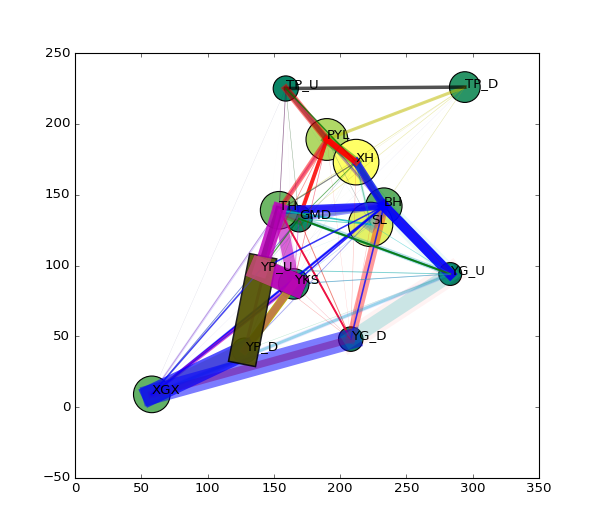

In [80]:
from matplotlib.pyplot import cm
max_weight = float(net.weight.max())
max_gap = float(2000)
for i in range(len(net)):
    plt.plot([net.x_x[i], net.x_y[i]],[net.y_x[i], net.y_y[i]], alpha = net.weight[i]/2500.0, linewidth=net.weight[i]/max_weight*50);
for i in range(len(area)):
    plt.text(area.x[i], area.y[i], area.area[i])
plt.scatter(area_stay.x, area_stay.y, s=np.sqrt(area_stay.gap)*200, c=area_stay.gap, cmap='summer', linewidth=1)

<IPython.core.display.Javascript object>


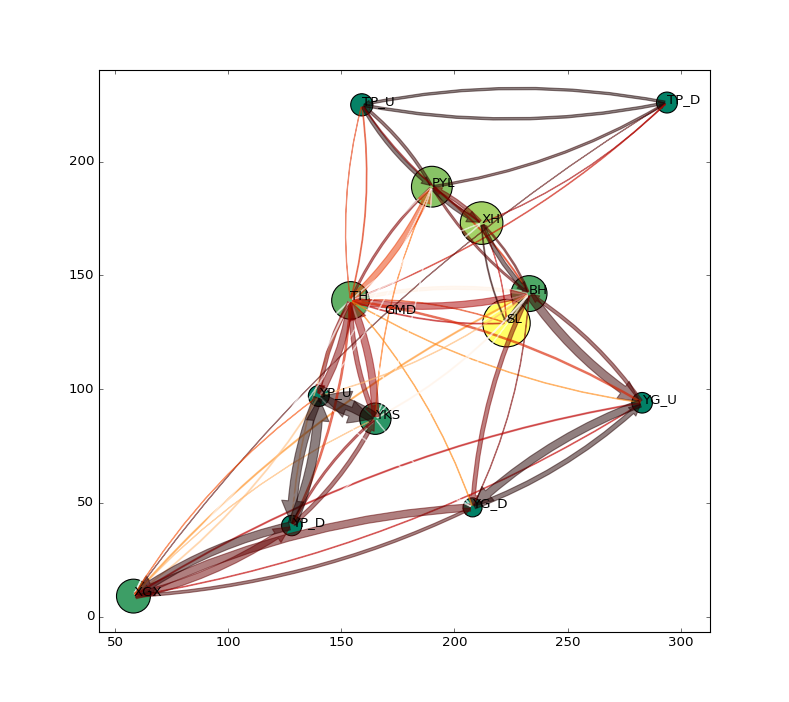

In [125]:
import matplotlib.patches as mpatches
import pylab
cm = pylab.get_cmap('gist_heat')
max_weight = float(net.weight.max())
max_gap = net.gap.max()
max_gap = float(60)

for i in range(len(net)):
    if net.weight[i]>max_weight*0.01:
        plt.annotate('',(net.x_x[i], net.y_x[i]),(net.x_y[i], net.y_y[i]),ha="right", size=net.weight[i]/max_weight*100, 
                     arrowprops=dict(arrowstyle='simple',fc=cm(net.gap[i]/max_gap), ec=cm(net.gap[i]/max_gap),
                     alpha =0.5, connectionstyle="arc3,rad=0.1"))
for i in range(len(area)):
    plt.text(area.x[i], area.y[i], area.area[i])
plt.scatter(area_stay.x, area_stay.y, s=np.sqrt(area_stay.gap)*200, c=area_stay.gap, cmap='summer', linewidth=1)

<IPython.core.display.Javascript object>


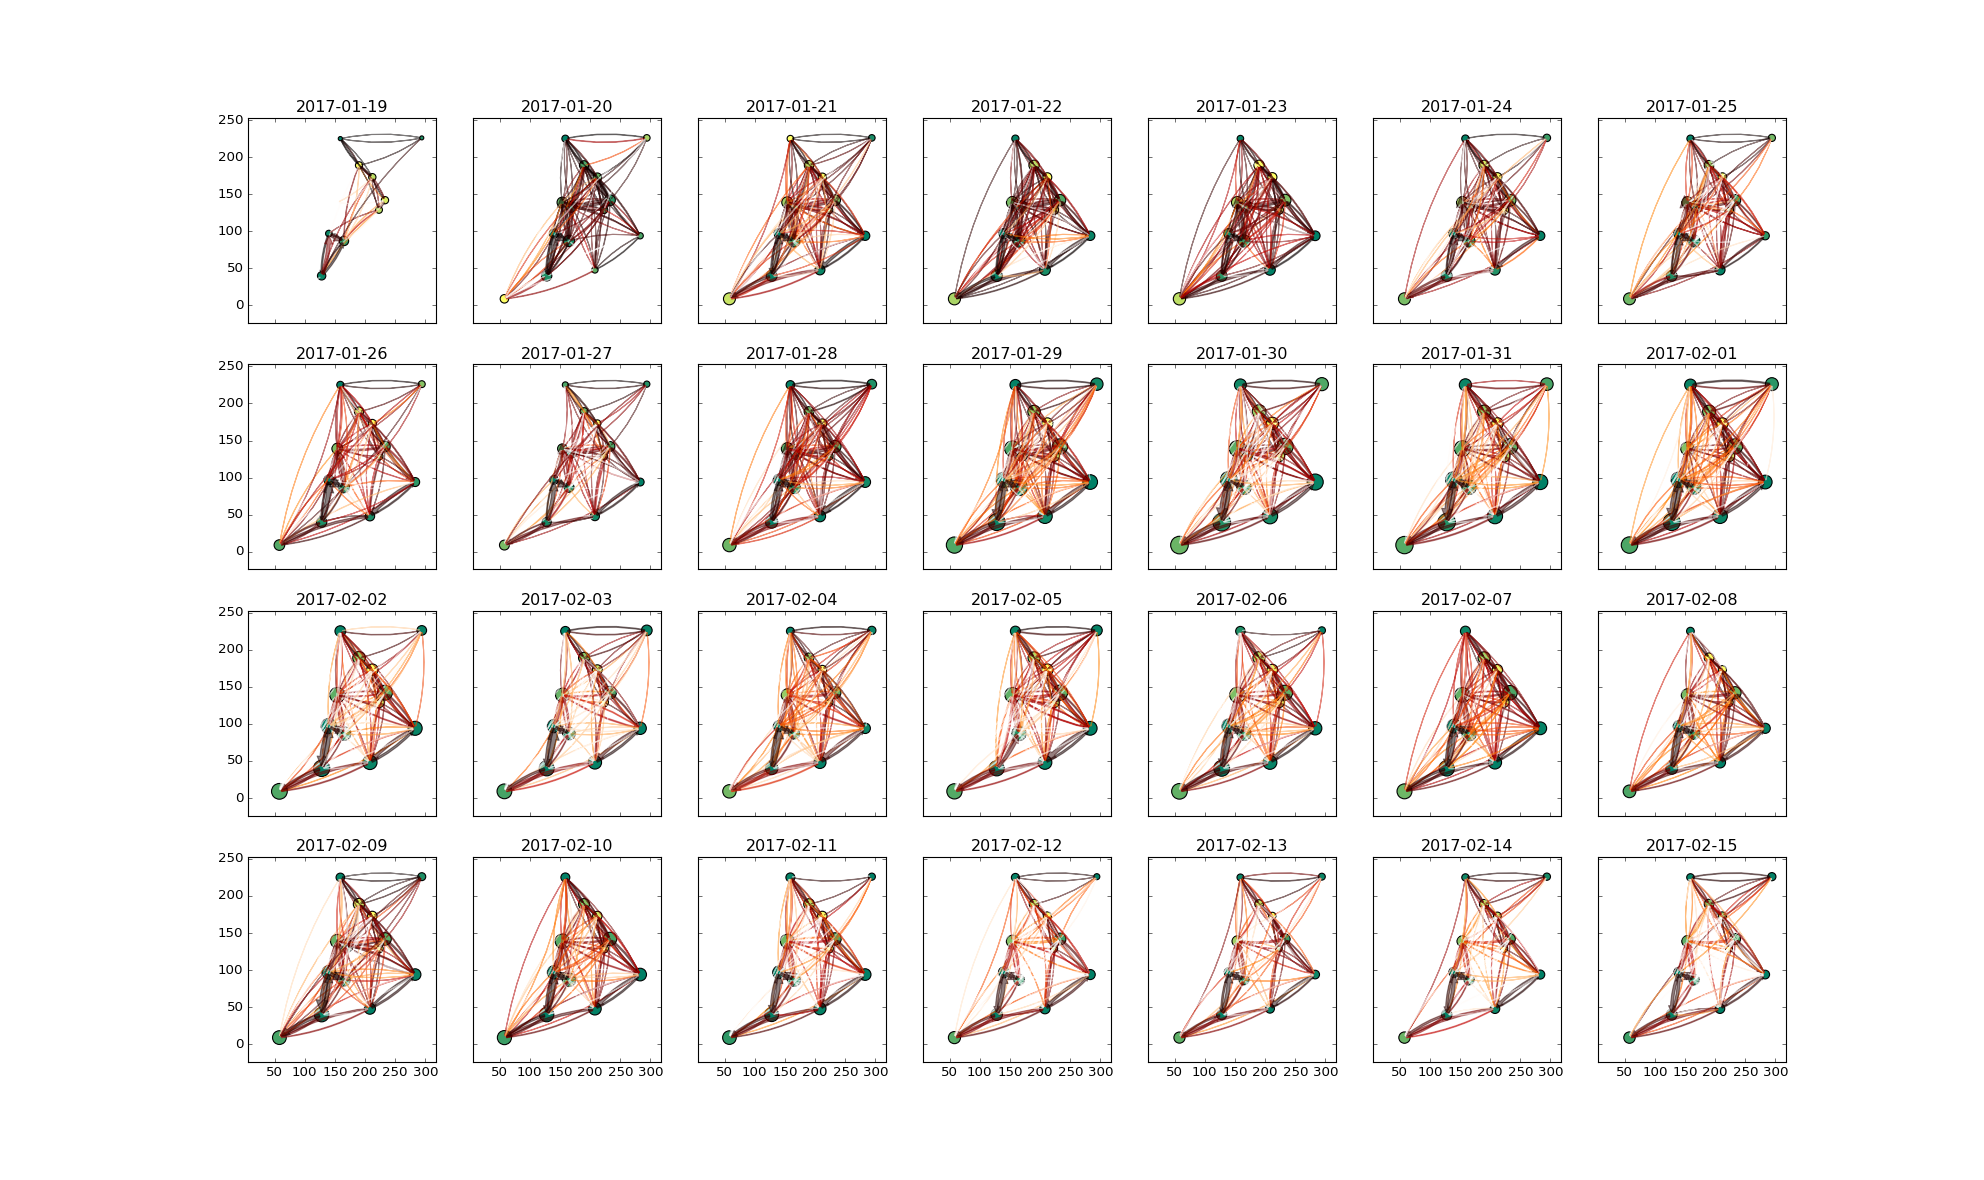

3400 226.99017287 38.7183098592
16835 236.11872278 91.7405063291
24353 123.803184152 124.248554913
29446 202.462463942 160.024390244
29977 182.857978192 163.88125
29525 114.679498819 146.685393258
27735 81.1498500499 139.114942529
18947 86.6015911421 101.425925926
13910 72.4419695072 76.31875
37246 97.3015494486 181.846994536
106165 81.9623831701 478.671794872
134997 86.0234246748 596.07253886
112473 95.1853194184 563.427710843
93546 95.879683211 465.535714286
84034 71.811588986 444.416149068
57578 59.9951367063 301.44375
34043 62.0717282369 177.580246914
68483 64.956027978 342.5
76848 76.9677373818 423.692307692
69160 86.045878175 403.115646259
29996 74.0956386826 168.933774834
51696 83.7931268144 254.877094972
54275 77.8597713622 317.664383562
46239 53.4662268033 261.85620915
27136 46.7057996407 148.391025641
16594 61.0985206289 98.0479452055
18817 52.1395675209 108.960264901
20779 48.0700863553 114.107594937


In [132]:
fig, axes = plt.subplots(4, 7, sharex='all', sharey='all')
cm = pylab.get_cmap('gist_heat')
for i in range(28):
    temp = area_flow[(area_flow.date-area_flow.date.min())/pd.Timedelta(days=1)==i]
    net = temp.groupby(by=['area_id','area_next']).apply(len).reset_index(name='weight')
    gap = temp.groupby(by=['area_id','area_next']).gap.mean().reset_index(name='gap')
    net = pd.merge(net, gap, on=['area_id','area_next'])
    area.columns = ['area','x','y','area_id']
    net = pd.merge(net, area)
    area.columns = ['area','x','y','area_next']
    net = pd.merge(net, area, on='area_next')
    area_stay = temp[temp.area_id == temp.area_next].groupby('area_id').gap.mean().reset_index(name='gap')
    area_stay_cnt = temp[temp.area_id == temp.area_next].groupby('area_id').size().reset_index(name='cnt')
    area.columns = ['area','x','y','area_id']
    area_stay = pd.merge(area_stay, area)
    mean_weight = float(net.weight.mean())
    mean_gap = net.gap.mean()
    print len(temp), mean_gap, mean_weight
    for j in range(len(net)):
        if net.weight[j]>max_weight*0.015:
            axes[i/7, i%7].annotate('',(net.x_x[j], net.y_x[j]),(net.x_y[j], net.y_y[j]),ha="right", size=net.weight[j]/mean_weight*3.0, 
                         arrowprops=dict(arrowstyle='simple',fc=cm(net.gap[j]/mean_gap), ec=cm(net.gap[j]/mean_gap),
                         alpha =0.5, connectionstyle="arc3,rad=0.1"))
    axes[i/7, i%7].scatter(area_stay.x, area_stay.y, s=np.sqrt(area_stay_cnt.cnt*10.0), c=area_stay.gap, cmap='summer', linewidth=1)
    axes[i/7, i%7].set_title(str(area_flow.date.min()+i*pd.Timedelta(days=1))[:10]);

In [130]:
area_stay

,area_id,gap,area,x,y
0,0,27.182013,BH,233,142
1,2,45.316498,PYL,190,189
2,3,83.384615,SL,223,129
3,4,32.710945,TH,154,139
4,5,3.145329,TP_D,294,226
5,6,3.955446,TP_U,159,225
6,7,21.619176,XGX,58,9
7,8,53.941980,XH,212,173
8,9,2.139405,YG_D,208,48
9,10,2.941019,YG_U,283,94
